<a href="https://colab.research.google.com/github/jeya014/Intelligent-Garbage-Classification-using-Deep-Learning/blob/main/Intelligent%20Garbage%20Classification%20using%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image as im
import cv2

In [22]:


# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [23]:

BATCH_SIZE = 64
img_height = 244
img_width = 244

Load Dataset
# load dataset

In [13]:
import os
data_path = '/content/drive/MyDrive/data'
os.listdir(data_path)

['train', 'test']

In [25]:


input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

In [26]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 156 files belonging to 6 classes.
Using 125 files for training.


In [27]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 156 files belonging to 6 classes.
Using 31 files for validation.


In [28]:

class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


#
# **dataset visuyalization **

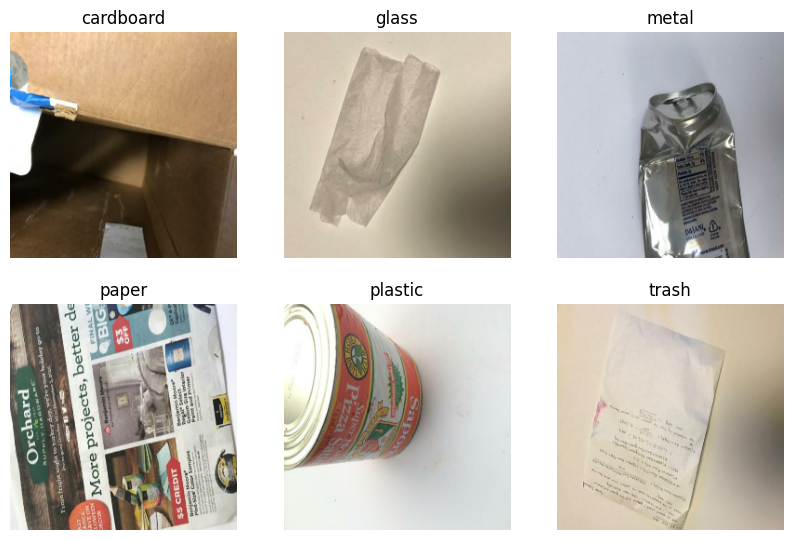

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [17]:

data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


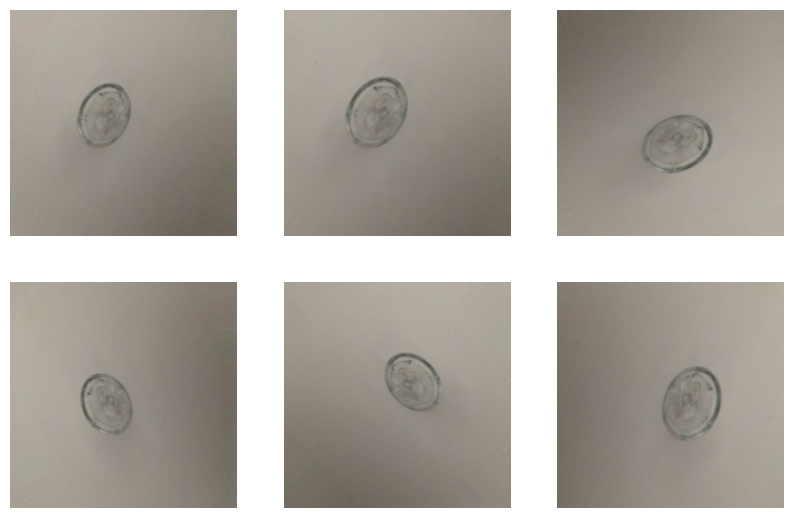

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [19]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture**


* **VGG -16 Base Model**  




In [20]:

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [22]:


print_layer_trainable()

True:	input_layer_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [24]:


base_model.trainable = False

In [25]:


for layer in base_model.layers:
    layer.trainable = False


In [26]:


print_layer_trainable()

False:	input_layer_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [55]:

in_path = data_path
curr_path = in_path + '/' + 'train'

(156, 224, 224, 3) (156,)


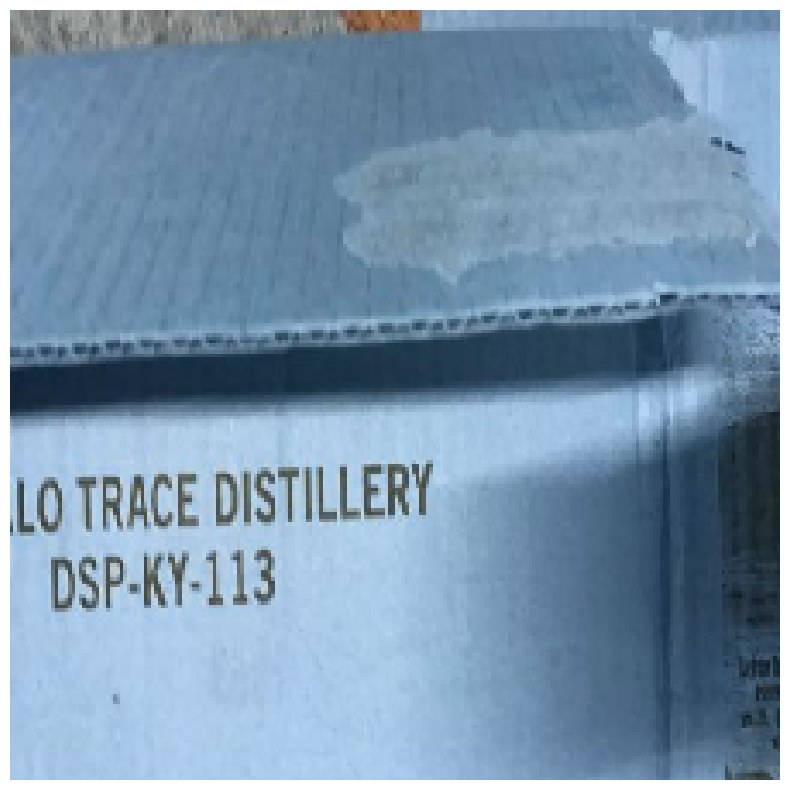

In [56]:
train_data = []
train_labels = []
classes = 6 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        train_data.append(img)
        train_labels.append(i)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

In [57]:


test_data = []
test_labels = []
classes = 7 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        test_data.append(img)
        test_labels.append(i)


test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(156, 224, 224, 3) (156,)


In [58]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(curr_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')

Found 156 images belonging to 6 classes.


In [59]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

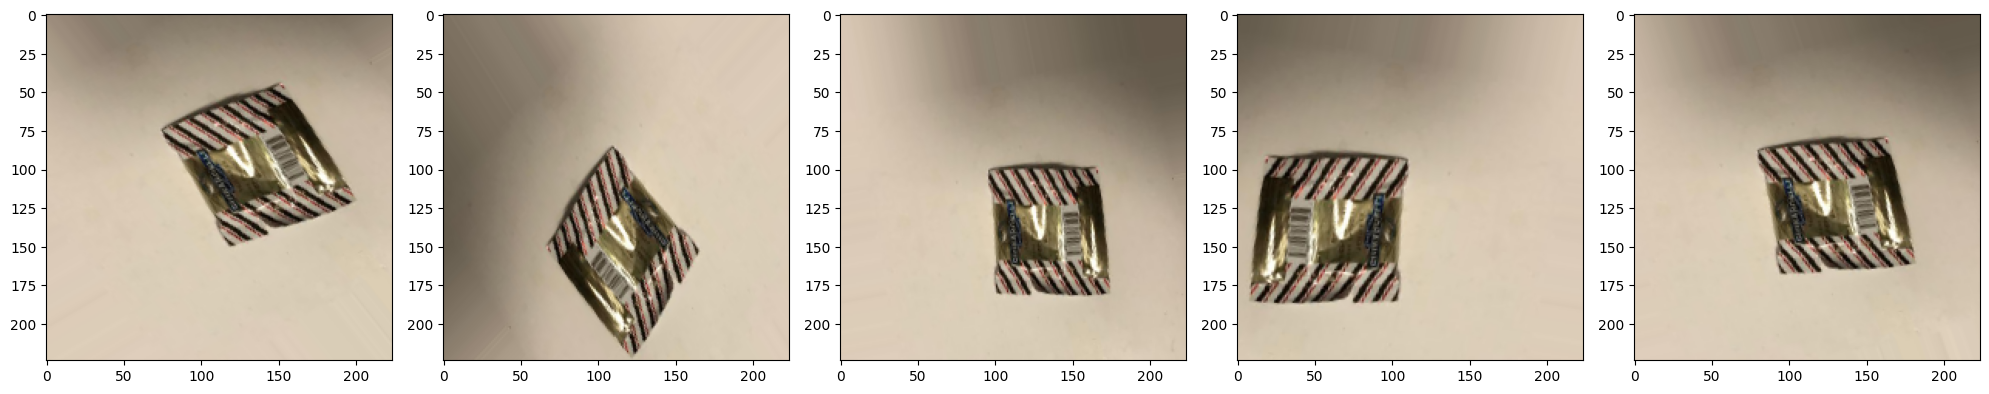

In [60]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

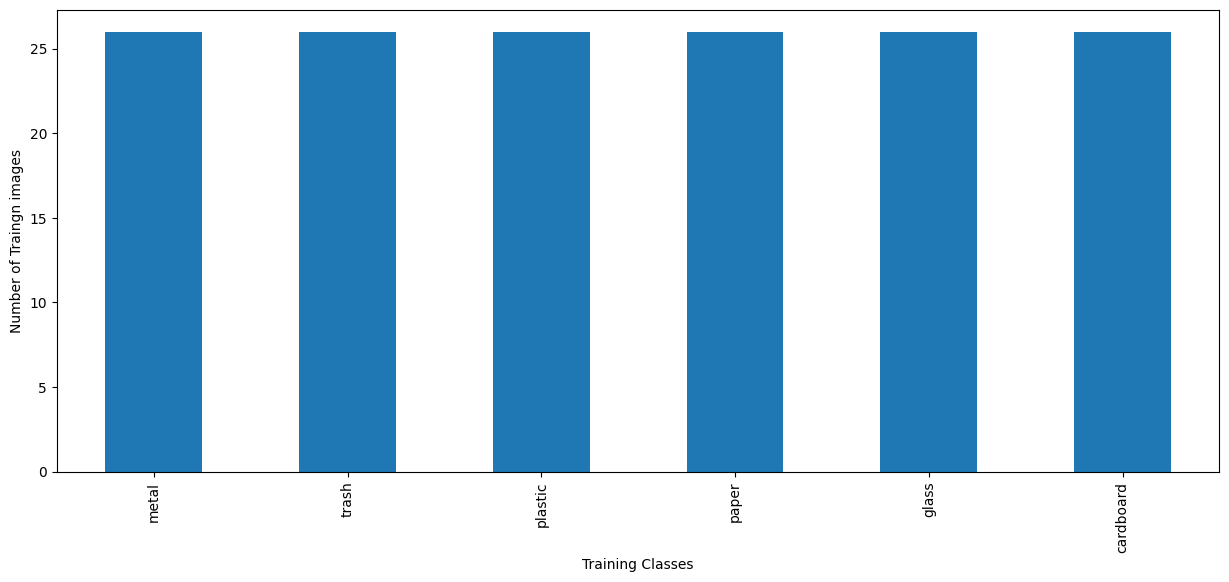

In [61]:
data_dic = {}
for folder in os.listdir(curr_path):
    data_dic[folder] = len(os.listdir(curr_path+ '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

In [62]:
testing_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
testing_data = testing_datagen.flow_from_directory(curr_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')

Found 156 images belonging to 6 classes.


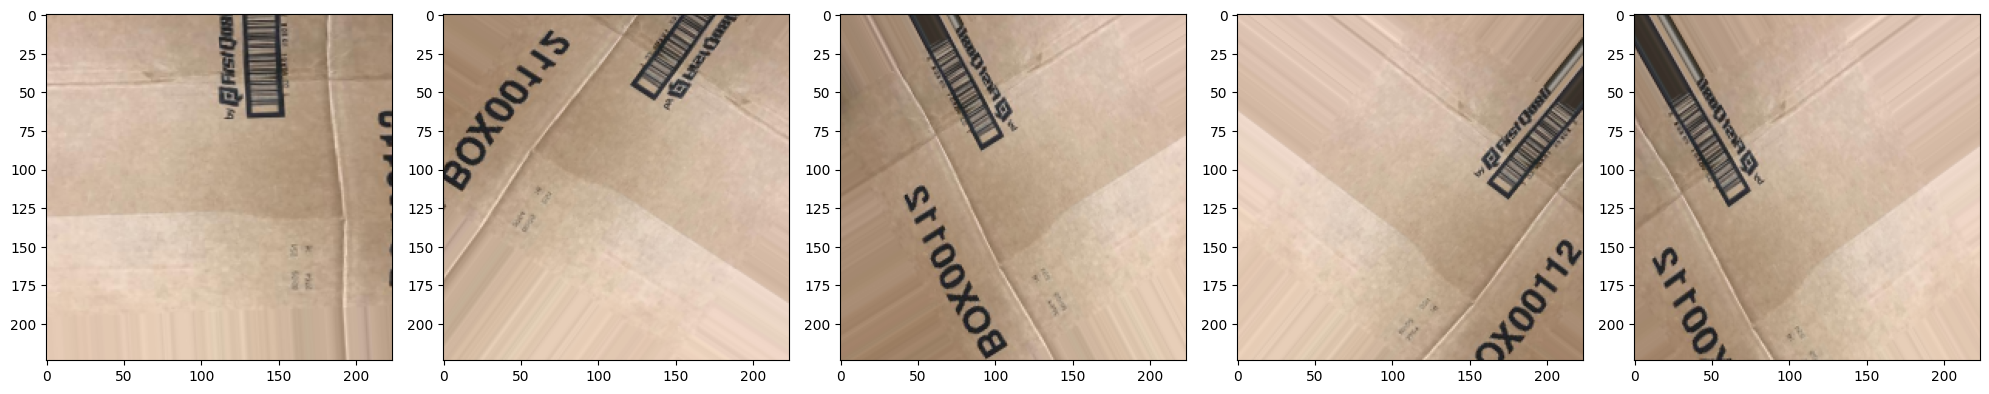

In [63]:
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Valedation images')

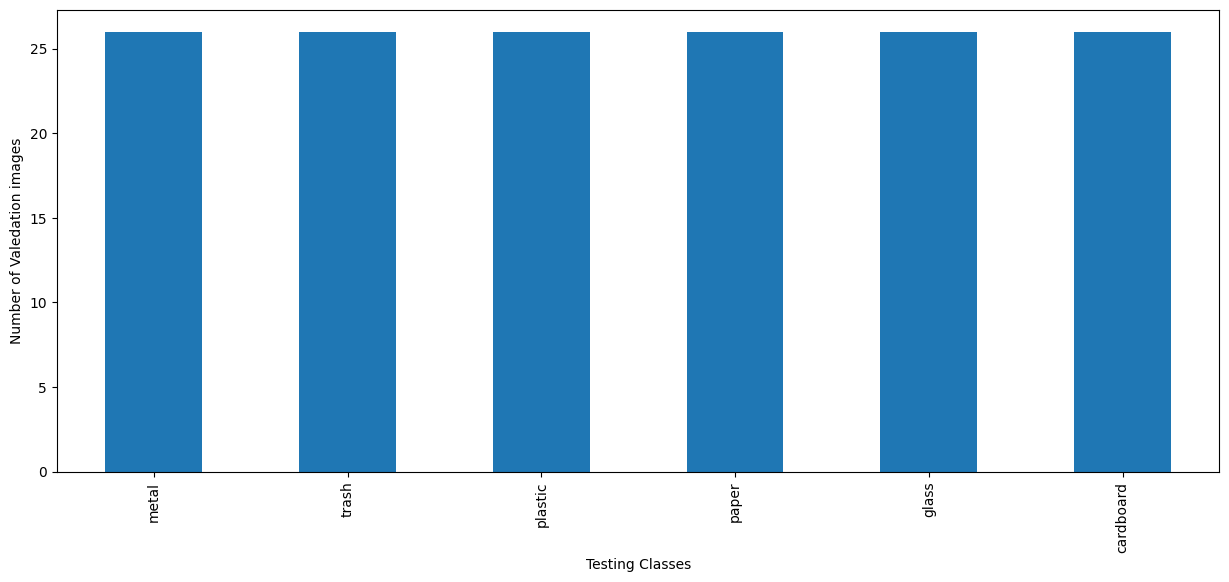

In [64]:
data_dic = {}
for folder in os.listdir(curr_path):
    data_dic[folder] = len(os.listdir(curr_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Valedation images')

# **CNN - RESNET50 Architeture using Tranfer Learning**

In [69]:
from keras.applications.resnet50 import ResNet50

In [99]:
# Define the image size to match the expected input size of ResNet50
IMAGE_SIZE = (224, 224)  # ResNet50 expects images of 224x224

# Add preprocessing layer to the front of ResNet50
from tensorflow.keras.applications import ResNet50

RESNET50 = ResNet50(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)


In [97]:
# don't train existing weights
for layer in RESNET50.layers:
    layer.trainable = False

In [98]:
num_classes = 6 # Replace 7 with your actual number of classes
prediction = Dense(num_classes, activation='softmax')(x)

In [96]:
import os

# Assuming your class folders are in a directory called 'dataset/train' or similar
did_dir ='/content/drive/MyDrive/data'  # Replace with your actual path
folders = os.listdir(did_dir)
num_classes = len(folders)

# Now you can use num_classes in your Dense layer
prediction = Dense(num_classes, activation='softmax')(x)

In [85]:
# create a model object
model_RESNET50 = Model(inputs=RESNET50.input, outputs=prediction)
# view the structure of the model
model_RESNET50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,788,418 (90.75 MB)

 Trainable params: 200,706 (784.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)